In [7]:
import sys

sys.path.insert(0, '..')

In [123]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction, TimeSeriesTransformerModel 
from transformers.models.time_series_transformer.modeling_time_series_transformer import TimeSeriesTransformerEncoder
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy import stats
import json 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
from core.multimodal.dataset import collate_fn, ASASSNVarStarDataset
from functools import partial
import matplotlib.pyplot as plt

In [9]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True

In [10]:
datapath = Path('/home/mrizhko/AML/AstroML/data/asaasn')
ds_train = ASASSNVarStarDataset(datapath, mode='train', verbose=True, only_periodic=True, recalc_period=False, 
                                prime=True, use_bands=['v', 'g'], only_sources_with_spectra=True, return_phased=True, 
                                fill_value=0)

Opening v data files... Found 687695 sources. done.
Opening g data files... Found 378861 sources. done.
Opening spectra csv... done.
Keeping only v band sources with spectra... Left with 26401 sources. done.
Keeping only g band sources with spectra... Left with 25954 sources. done.
Removing duplicates for v band... Left with 25950. done.
Removing duplicates for g band... Left with 25950. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for v band... Left with 22680. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for g band... Left with 25536. done.
Merging bands... done. Now 22447 sources.
Removed non-periodic sources. Now 22447 sources.
Total: 22447, Train: 17957, Val: 2244, Test: 2246
Priming tarballs by doing initial scan... done.


In [203]:
idx = [1]
sources = ds_train.df.iloc[idx]
lcs = ds_train.get_light_curves(sources)

In [209]:
lcs[0][0].dtype == float

True

In [214]:
bad_ids = []

for i in tqdm(range(len(ds_train))):
    idx = [i]
    sources = ds_train.df.iloc[idx]
    lcs = ds_train.get_light_curves(sources)

    if lcs[0][0].dtype != float or lcs[0][1].dtype != float:
        bad_ids.append(i)

100%|███████████████████████████████████████████████████████████| 17957/17957 [07:14<00:00, 41.33it/s]


In [215]:
len(bad_ids)

181

In [11]:
ds_val = ASASSNVarStarDataset(datapath, mode='val', verbose=True, only_periodic=True, recalc_period=False, 
                              prime=True, use_bands=['v', 'g'], only_sources_with_spectra=True, return_phased=True, 
                              fill_value=0)

Opening v data files... Found 687695 sources. done.
Opening g data files... Found 378861 sources. done.
Opening spectra csv... done.
Keeping only v band sources with spectra... Left with 26401 sources. done.
Keeping only g band sources with spectra... Left with 25954 sources. done.
Removing duplicates for v band... Left with 25950. done.
Removing duplicates for g band... Left with 25950. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for v band... Left with 22680. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for g band... Left with 25536. done.
Merging bands... done. Now 22447 sources.
Removed non-periodic sources. Now 22447 sources.
Total: 22447, Train: 17957, Val: 2244, Test: 2246
Priming tarballs by doing initial scan... done.


In [139]:
class SpectraDataset(Dataset):
    def __init__(self, asassn_dataset):
        self.asassn_dataset = asassn_dataset

    def __len__(self):
        return len(self.asassn_dataset)

    def __getitem__(self, idx):
        el = self.asassn_dataset[idx]
        spectra = el['spectra'][0][0]
        label = el['classes'][0][0].astype(np.int64)

        wavelengths, fluxes = spectra[:, 0], spectra[:, 1]
        fluxes = fluxes / fluxes.std()
        
        regular_wavelengths = np.arange(3800, 9000)
        interpolated_fluxes = np.interp(regular_wavelengths, wavelengths, fluxes)
        interpolated_fluxes = interpolated_fluxes.reshape(1, -1).astype(np.float32)
        
        return interpolated_fluxes, label

In [140]:
train_dataset = SpectraDataset(ds_train)
val_dataset = SpectraDataset(ds_val)

In [169]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [191]:
class GalSpecNet(nn.Module):
    """https://academic.oup.com/mnras/article/527/1/1163/7283157"""
    
    def __init__(self, num_classes):
        super(GalSpecNet, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=0)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=0)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=0)

        self.mp1 = nn.MaxPool1d(kernel_size=4)
        self.mp2 = nn.MaxPool1d(kernel_size=4)
        self.mp3 = nn.MaxPool1d(kernel_size=4)

        self.fc1 = nn.Linear(2496, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.mp1(self.conv1(x)))
        x = F.relu(self.mp2(self.conv2(x)))
        x = F.relu(self.mp3(self.conv3(x)))
        x = F.relu(self.conv4(x))        
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [192]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print('Using', device)

Using cuda:7


In [193]:
model = GalSpecNet(len(ds_train.target_lookup))
model = model.to(device)

In [194]:
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [195]:
def train_epoch():
    model.train()
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    for fluxes, label in tqdm(train_dataloader):
        fluxes, label = fluxes.to(device), label.to(device)

        optimizer.zero_grad()

        logits = model(fluxes)
        loss = criterion(logits, label)
        total_loss.append(loss.item())

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == label).sum().item()

        total_correct_predictions += correct_predictions
        total_predictions += label.size(0)

        loss.backward()
        optimizer.step()

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [196]:
def val_epoch():
    model.eval()
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for fluxes, label in tqdm(val_dataloader):
            fluxes, label = fluxes.to(device), label.to(device)

            logits = model(fluxes)
            loss = criterion(logits, label)
            total_loss.append(loss.item())

            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == label).sum().item()
    
            total_correct_predictions += correct_predictions
            total_predictions += label.size(0)

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [197]:
for i in range(10):
    print(f'Epoch {i}')
    
    train_loss, train_acc = train_epoch()
    print(f'Train Loss: {round(train_loss, 3)} Acc: {round(train_acc, 2)}')
    
    val_loss, val_acc = val_epoch()
    print(f'Val Loss: {round(val_loss, 3)} Acc: {round(val_acc, 2)}')

Epoch 0


 42%|███████████████████████████                                      | 15/36 [01:51<01:32,  4.42s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37fd905d80>
Traceback (most recent call last):
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37fd905d80>
Traceback (most recent call last):
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/dataloader

Train Loss: 1.816 Acc: 0.41


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.81s/it]


Val Loss: 1.338 Acc: 0.52
Epoch 1


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.44s/it]


Train Loss: 1.31 Acc: 0.53


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.74s/it]


Val Loss: 1.287 Acc: 0.52
Epoch 2


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:55<00:00,  6.53s/it]


Train Loss: 1.259 Acc: 0.55


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:49<00:00, 21.95s/it]


Val Loss: 1.228 Acc: 0.56
Epoch 3


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.43s/it]


Train Loss: 1.225 Acc: 0.56


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.69s/it]


Val Loss: 1.238 Acc: 0.52
Epoch 4


100%|█████████████████████████████████████████████████████████████████| 36/36 [04:02<00:00,  6.74s/it]


Train Loss: 1.201 Acc: 0.56


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.51s/it]


Val Loss: 1.215 Acc: 0.56
Epoch 5


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:48<00:00,  6.36s/it]


Train Loss: 1.172 Acc: 0.58


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.66s/it]


Val Loss: 1.252 Acc: 0.53
Epoch 6


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:49<00:00,  6.37s/it]


Train Loss: 1.149 Acc: 0.59


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.78s/it]


Val Loss: 1.154 Acc: 0.58
Epoch 7


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:46<00:00,  6.29s/it]


Train Loss: 1.118 Acc: 0.6


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.81s/it]


Val Loss: 1.125 Acc: 0.6
Epoch 8


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:50<00:00,  6.41s/it]


Train Loss: 1.082 Acc: 0.61


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:41<00:00, 20.35s/it]


Val Loss: 1.037 Acc: 0.63
Epoch 9


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:49<00:00,  6.38s/it]


Train Loss: 1.015 Acc: 0.64


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.44s/it]

Val Loss: 1.003 Acc: 0.64


In [198]:
for i in range(10, 100):
    print(f'Epoch {i}')
    
    train_loss, train_acc = train_epoch()
    print(f'Train Loss: {round(train_loss, 3)} Acc: {round(train_acc, 2)}')
    
    val_loss, val_acc = val_epoch()
    print(f'Val Loss: {round(val_loss, 3)} Acc: {round(val_acc, 2)}')

Epoch 10


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:47<00:00,  6.32s/it]


Train Loss: 0.985 Acc: 0.64


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.69s/it]


Val Loss: 1.099 Acc: 0.61
Epoch 11


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:50<00:00,  6.41s/it]


Train Loss: 0.966 Acc: 0.65


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:41<00:00, 20.22s/it]


Val Loss: 0.947 Acc: 0.64
Epoch 12


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:56<00:00,  6.57s/it]


Train Loss: 0.917 Acc: 0.67


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.03s/it]


Val Loss: 0.908 Acc: 0.67
Epoch 13


100%|█████████████████████████████████████████████████████████████████| 36/36 [04:03<00:00,  6.76s/it]


Train Loss: 0.879 Acc: 0.68


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.24s/it]


Val Loss: 0.869 Acc: 0.68
Epoch 14


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:54<00:00,  6.52s/it]


Train Loss: 0.832 Acc: 0.69


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:43<00:00, 20.61s/it]


Val Loss: 0.908 Acc: 0.67
Epoch 15


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:59<00:00,  6.67s/it]


Train Loss: 0.82 Acc: 0.71


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.84s/it]


Val Loss: 0.887 Acc: 0.68
Epoch 16


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:52<00:00,  6.45s/it]


Train Loss: 0.792 Acc: 0.71


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.81s/it]


Val Loss: 0.918 Acc: 0.69
Epoch 17


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:49<00:00,  6.38s/it]


Train Loss: 0.789 Acc: 0.72


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.97s/it]


Val Loss: 0.795 Acc: 0.72
Epoch 18


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:50<00:00,  6.39s/it]


Train Loss: 0.755 Acc: 0.73


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:41<00:00, 20.24s/it]


Val Loss: 0.872 Acc: 0.7
Epoch 19


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:53<00:00,  6.48s/it]


Train Loss: 0.769 Acc: 0.73


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.42s/it]


Val Loss: 0.794 Acc: 0.72
Epoch 20


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:58<00:00,  6.61s/it]


Train Loss: 0.755 Acc: 0.73


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.56s/it]


Val Loss: 0.814 Acc: 0.7
Epoch 21


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:49<00:00,  6.38s/it]


Train Loss: 0.733 Acc: 0.73


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.02s/it]


Val Loss: 0.769 Acc: 0.73
Epoch 22


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:47<00:00,  6.33s/it]


Train Loss: 0.726 Acc: 0.74


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.64s/it]


Val Loss: 0.772 Acc: 0.73
Epoch 23


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:50<00:00,  6.40s/it]


Train Loss: 0.715 Acc: 0.74


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.36s/it]


Val Loss: 0.783 Acc: 0.72
Epoch 24


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.43s/it]


Train Loss: 0.697 Acc: 0.75


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.39s/it]


Val Loss: 0.752 Acc: 0.72
Epoch 25


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:59<00:00,  6.64s/it]


Train Loss: 0.69 Acc: 0.75


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.16s/it]


Val Loss: 0.811 Acc: 0.72
Epoch 26


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:48<00:00,  6.34s/it]


Train Loss: 0.697 Acc: 0.75


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.34s/it]


Val Loss: 0.94 Acc: 0.67
Epoch 27


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:49<00:00,  6.38s/it]


Train Loss: 0.685 Acc: 0.75


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.94s/it]


Val Loss: 0.743 Acc: 0.73
Epoch 28


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:52<00:00,  6.45s/it]


Train Loss: 0.658 Acc: 0.76


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.74s/it]


Val Loss: 0.762 Acc: 0.72
Epoch 29


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:56<00:00,  6.58s/it]


Train Loss: 0.652 Acc: 0.76


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.04s/it]


Val Loss: 0.783 Acc: 0.72
Epoch 30


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.44s/it]


Train Loss: 0.652 Acc: 0.76


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.37s/it]


Val Loss: 0.794 Acc: 0.71
Epoch 31


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:48<00:00,  6.34s/it]


Train Loss: 0.637 Acc: 0.77


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.11s/it]


Val Loss: 0.738 Acc: 0.74
Epoch 32


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:55<00:00,  6.56s/it]


Train Loss: 0.62 Acc: 0.77


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.79s/it]


Val Loss: 0.736 Acc: 0.74
Epoch 33


 44%|████████████████████████████▉                                    | 16/36 [01:44<01:03,  3.19s/it]Skipping line 145: expected 8 fields, saw 13

100%|█████████████████████████████████████████████████████████████████| 36/36 [03:50<00:00,  6.39s/it]


Train Loss: 0.618 Acc: 0.77


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.30s/it]


Val Loss: 0.763 Acc: 0.72
Epoch 34


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:49<00:00,  6.39s/it]


Train Loss: 0.623 Acc: 0.77


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.69s/it]


Val Loss: 0.731 Acc: 0.74
Epoch 35


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.42s/it]


Train Loss: 0.617 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.57s/it]


Val Loss: 0.728 Acc: 0.74
Epoch 36


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.43s/it]


Train Loss: 0.603 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.64s/it]


Val Loss: 0.731 Acc: 0.74
Epoch 37


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.43s/it]


Train Loss: 0.587 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.38s/it]


Val Loss: 0.764 Acc: 0.73
Epoch 38


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:50<00:00,  6.40s/it]


Train Loss: 0.592 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.54s/it]


Val Loss: 0.727 Acc: 0.74
Epoch 39


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:46<00:00,  6.29s/it]


Train Loss: 0.579 Acc: 0.79


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.30s/it]


Val Loss: 0.717 Acc: 0.74
Epoch 40


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:49<00:00,  6.39s/it]


Train Loss: 0.56 Acc: 0.8


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.54s/it]


Val Loss: 0.75 Acc: 0.74
Epoch 41


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:50<00:00,  6.40s/it]


Train Loss: 0.559 Acc: 0.79


100%|███████████████████████████████████████████████████████████████████| 5/5 [02:00<00:00, 24.15s/it]


Val Loss: 0.767 Acc: 0.73
Epoch 42


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:52<00:00,  6.46s/it]


Train Loss: 0.553 Acc: 0.8


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.32s/it]


Val Loss: 0.871 Acc: 0.69
Epoch 43


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:49<00:00,  6.36s/it]


Train Loss: 0.568 Acc: 0.79


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.61s/it]


Val Loss: 0.838 Acc: 0.7
Epoch 44


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.44s/it]


Train Loss: 0.559 Acc: 0.79


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.11s/it]


Val Loss: 0.727 Acc: 0.75
Epoch 45


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:48<00:00,  6.35s/it]


Train Loss: 0.548 Acc: 0.8


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.05s/it]


Val Loss: 0.763 Acc: 0.73
Epoch 46


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:56<00:00,  6.57s/it]


Train Loss: 0.535 Acc: 0.8


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.73s/it]


Val Loss: 0.762 Acc: 0.74
Epoch 47


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:50<00:00,  6.40s/it]


Train Loss: 0.535 Acc: 0.8


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:43<00:00, 20.78s/it]


Val Loss: 0.748 Acc: 0.75
Epoch 48


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.43s/it]


Train Loss: 0.511 Acc: 0.81


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:45<00:00, 21.17s/it]


Val Loss: 0.746 Acc: 0.75
Epoch 49


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:49<00:00,  6.38s/it]


Train Loss: 0.5 Acc: 0.82


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.16s/it]


Val Loss: 0.764 Acc: 0.75
Epoch 50


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:53<00:00,  6.49s/it]


Train Loss: 0.496 Acc: 0.82


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.27s/it]


Val Loss: 0.807 Acc: 0.74
Epoch 51


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.43s/it]


Train Loss: 0.5 Acc: 0.81


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.30s/it]


Val Loss: 0.776 Acc: 0.75
Epoch 52


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:53<00:00,  6.49s/it]


Train Loss: 0.486 Acc: 0.82


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.41s/it]


Val Loss: 0.845 Acc: 0.72
Epoch 53


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:47<00:00,  6.33s/it]


Train Loss: 0.487 Acc: 0.82


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.26s/it]


Val Loss: 0.795 Acc: 0.73
Epoch 54


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:54<00:00,  6.52s/it]


Train Loss: 0.477 Acc: 0.82


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.07s/it]


Val Loss: 0.823 Acc: 0.74
Epoch 55


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:52<00:00,  6.47s/it]


Train Loss: 0.469 Acc: 0.82


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.89s/it]


Val Loss: 0.79 Acc: 0.74
Epoch 56


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:52<00:00,  6.47s/it]


Train Loss: 0.453 Acc: 0.83


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.61s/it]


Val Loss: 0.8 Acc: 0.74
Epoch 57


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:53<00:00,  6.49s/it]


Train Loss: 0.452 Acc: 0.83


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.03s/it]


Val Loss: 0.834 Acc: 0.74
Epoch 58


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:53<00:00,  6.48s/it]


Train Loss: 0.456 Acc: 0.83


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.49s/it]


Val Loss: 0.839 Acc: 0.74
Epoch 59


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.44s/it]


Train Loss: 0.441 Acc: 0.84


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.55s/it]


Val Loss: 0.888 Acc: 0.72
Epoch 60


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:52<00:00,  6.46s/it]


Train Loss: 0.455 Acc: 0.83


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.19s/it]


Val Loss: 0.848 Acc: 0.74
Epoch 61


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:49<00:00,  6.37s/it]


Train Loss: 0.444 Acc: 0.83


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:43<00:00, 20.64s/it]


Val Loss: 0.851 Acc: 0.74
Epoch 62


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:54<00:00,  6.52s/it]


Train Loss: 0.419 Acc: 0.84


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.67s/it]


Val Loss: 0.837 Acc: 0.75
Epoch 63


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.44s/it]


Train Loss: 0.422 Acc: 0.84


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.03s/it]


Val Loss: 0.864 Acc: 0.74
Epoch 64


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:54<00:00,  6.52s/it]


Train Loss: 0.428 Acc: 0.84


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.72s/it]


Val Loss: 0.884 Acc: 0.74
Epoch 65


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:57<00:00,  6.59s/it]


Train Loss: 0.412 Acc: 0.85


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.38s/it]


Val Loss: 0.886 Acc: 0.74
Epoch 66


100%|█████████████████████████████████████████████████████████████████| 36/36 [03:51<00:00,  6.44s/it]


Train Loss: 0.395 Acc: 0.85


100%|███████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.08s/it]


Val Loss: 0.937 Acc: 0.71
Epoch 67


 22%|██████████████▋                                                   | 8/36 [00:54<01:29,  3.21s/it]

['2.85000' '2.79500' '2.81200' '2.69100' '2.64400' '2.62600' '2.59900'
 '2.53800' '2.50700' '2.63900' '2.89600' '2.59700' '2.62700' '2.61900'
 '2.60900' '2.52300' '2.51000' '2.58800' '2.55200' '2.56300' '2.61300'
 '2.62800' '2.67900' '2.69500' '2.61900' '2.59600' '2.76600' '2.82500'
 '2.80100' '2.74500' '2.70700' '2.85700' '2.72000' '2.60400' '2.93800'
 '2.60200' '2.85700' '2.82900' '2.64200' '2.73700' '3.04200' '2.99100'
 '3.06300' '2.87800' '2.91500' '2.86400' '2.89600' '2.59900' '2.57800'
 '3.43700' '3.21300' '3.11500' '2.93000' '3.05200' '2.92300' '2.61700'
 '2.73500' '2.89500' '2.92100' '3.05700' '2.82700' '2.91100' '2.69800'
 '2.88900' '2.71100' '2.89600' '2.99300' '2.91600' '2.83000' '2.86900'
 '2.75500' '2.82100' '2.77200' '2.87200' '2.85300' '2.82700' '2.88700'
 '2.78700' '2.76200' '2.74600' '2.78500' '2.62600' '2.70000' '2.64800'
 '2.63900' '2.81000' '2.45100' '2.63700' '3.00400' '2.67900' '2.70300'
 '2.72900' '2.80700' '2.69300' '2.94300' '2.76900' '2.82300' '3.00000'
 '2.82

 28%|██████████████████                                               | 10/36 [01:47<04:38, 10.73s/it]


TypeError: Caught TypeError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_3700739/2415286343.py", line 9, in __getitem__
    el = self.asassn_dataset[idx]
  File "/home/mrizhko/AML/AstroML/notebooks/../core/multimodal/dataset.py", line 455, in __getitem__
    return_dict["lcs"] = self.get_light_curves(sources)
  File "/home/mrizhko/AML/AstroML/notebooks/../core/multimodal/dataset.py", line 676, in get_light_curves
    t, y, yerr, _, _, _, _, _ = clip_outliers(
  File "/home/mrizhko/AML/AstroML/notebooks/../util/preprocess_data.py", line 47, in clip_outliers
    mag0 = np.average(m, weights=1/merr)
TypeError: unsupported operand type(s) for /: 'int' and 'str'


In [111]:
torch.save(model.state_dict(), f'weights-10.pth')

In [112]:
for i in range(10, 100):
    print(f'Epoch {i}')
    print('Train', train_epoch())
    print('Val', val_epoch())

    if i % 10 == 0:
        torch.save(model.state_dict(), f'weights-{i}.pth')

Epoch 10


100%|███████████████████████████████████████████████████████████████| 281/281 [03:50<00:00,  1.22it/s]


Train (0.8395245591728713, 0.6986690427131481)


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:35<00:00,  2.66s/it]


Val (0.8491414371463988, 0.6893939393939394)
Epoch 11


100%|███████████████████████████████████████████████████████████████| 281/281 [03:44<00:00,  1.25it/s]


Train (0.8193049763869561, 0.7043492788327672)


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:38<00:00,  2.73s/it]


Val (0.864031594660547, 0.6773618538324421)
Epoch 12


100%|███████████████████████████████████████████████████████████████| 281/281 [03:41<00:00,  1.27it/s]


Train (0.794019596856684, 0.7130923873698279)


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:42<00:00,  2.84s/it]


Val (0.7939012861914105, 0.7170231729055259)
Epoch 13


100%|███████████████████████████████████████████████████████████████| 281/281 [03:42<00:00,  1.26it/s]


Train (0.7806561073798726, 0.7163223255554937)


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:39<00:00,  2.76s/it]


Val (0.8309967368841171, 0.6978609625668449)
Epoch 14


 94%|██████████████████████████████████████████████████████████▉    | 263/281 [03:34<00:15,  1.18it/s]Skipping line 272: expected 8 fields, saw 10



['19.34800' '16.66800' '17.69100' '17.85400' '13.76500' '13.79300'
 '15.83500' '14.78500' '14.77700' '16.71500' '14.28300' '16.59800'
 '14.87800' '17.01100' '18.24800' '16.44200' '15.01000' '17.05100'
 '18.42200' '19.07700' '15.62300' '18.46500' '15.58900' '14.43700'
 '16.12100' '14.06100' '14.42600' '14.37800' '14.64300' '14.51500'
 '13.80200' '14.57500' '14.44100' '14.17900' '15.04200' '14.00700'
 '14.83800' '14.36000' '15.24100' '13.91200' '17.83300' '14.42800'
 '13.39800' '20.51700' '19.03000' '17.84200' '16.39000' '18.06800'
 '19.94100' '18.81400' '18.68800' '18.50800' '20.09400' '18.19700'
 '19.85200' '18.14500' '13.66100' '17.42100' '19.59200' '16.59200'
 '19.75600' '16.79800' '14.26300' '19.34100' '19.64200' '18.20700'
 '19.69100' '18.47800' '19.93100' '18.44400' '16.75100' '20.08900'
 '18.60500' '15.56300' '17.95700' '18.96500' '14.97300' '14.52700'
 '15.08800' '13.75900' '15.50400' '13.37500' '18.44000' '19.11600'
 '18.22900' '17.84900' '19.83300' '14.66600' '17.02300' '18.67

 97%|████████████████████████████████████████████████████████████▉  | 272/281 [03:39<00:07,  1.24it/s]


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_3700739/95341730.py", line 9, in __getitem__
    el = self.asassn_dataset[idx]
  File "/home/mrizhko/AML/AstroML/notebooks/../core/multimodal/dataset.py", line 455, in __getitem__
    return_dict["lcs"] = self.get_light_curves(sources)
  File "/home/mrizhko/AML/AstroML/notebooks/../core/multimodal/dataset.py", line 676, in get_light_curves
    t, y, yerr, _, _, _, _, _ = clip_outliers(
  File "/home/mrizhko/AML/AstroML/notebooks/../util/preprocess_data.py", line 47, in clip_outliers
    mag0 = np.average(m, weights=1/merr)
TypeError: unsupported operand type(s) for /: 'int' and 'str'


In [122]:
for i in tqdm(range(len(ds_train))):
    if ds_train[i]['spectra'][0][0][:, 1].dtype != np.float32:
        print(i)

100%|███████████████████████████████████████████████████████████| 17957/17957 [13:14<00:00, 22.59it/s]


In [ ]:
for i in tqdm(range(len(ds_train))):
    try:
        spectra = ds_train[i]['spectra'][0][0]
    except:
        print(i)
        break

 46%|███████████████████████████▋                                | 8285/17957 [06:20<07:00, 22.99it/s]

In [176]:
spec_filename = ds_train.spec_df[ds_train.spec_df['edr3_source_id'] == 'EDR3 1314026659889734400']['spec_filename'].iloc[0]

In [185]:
remove_filenames = []

for el in ds_train.spec_df['spec_filename']:
    filename = (ds_train.data_root / ds_train.lamost_spec_dir / el)

    if not os.path.exists(filename):
        remove_filenames.append(str(filename).split('/')[-1])

In [187]:
ds_train.spec_df[ds_train.spec_df['spec_filename'].isin(remove_filenames)].index

Index([ 1588,  1693,  1887,  3321,  3845,  4761,  5430,  8515,  9660, 11276,
       12231, 14104, 17493, 17716, 18451, 18900, 19074, 20292, 24786, 26316,
       26759, 30479, 30652, 30736, 31215, 33612, 39155, 40778, 41346],
      dtype='int64')

In [177]:
filename = (ds_train.data_root / ds_train.lamost_spec_dir / spec_filename)

if os.path.exists(filename):
    row_spectra.append(self._readLRSFits(filename))

In [178]:
os.path.exists(filename)

False

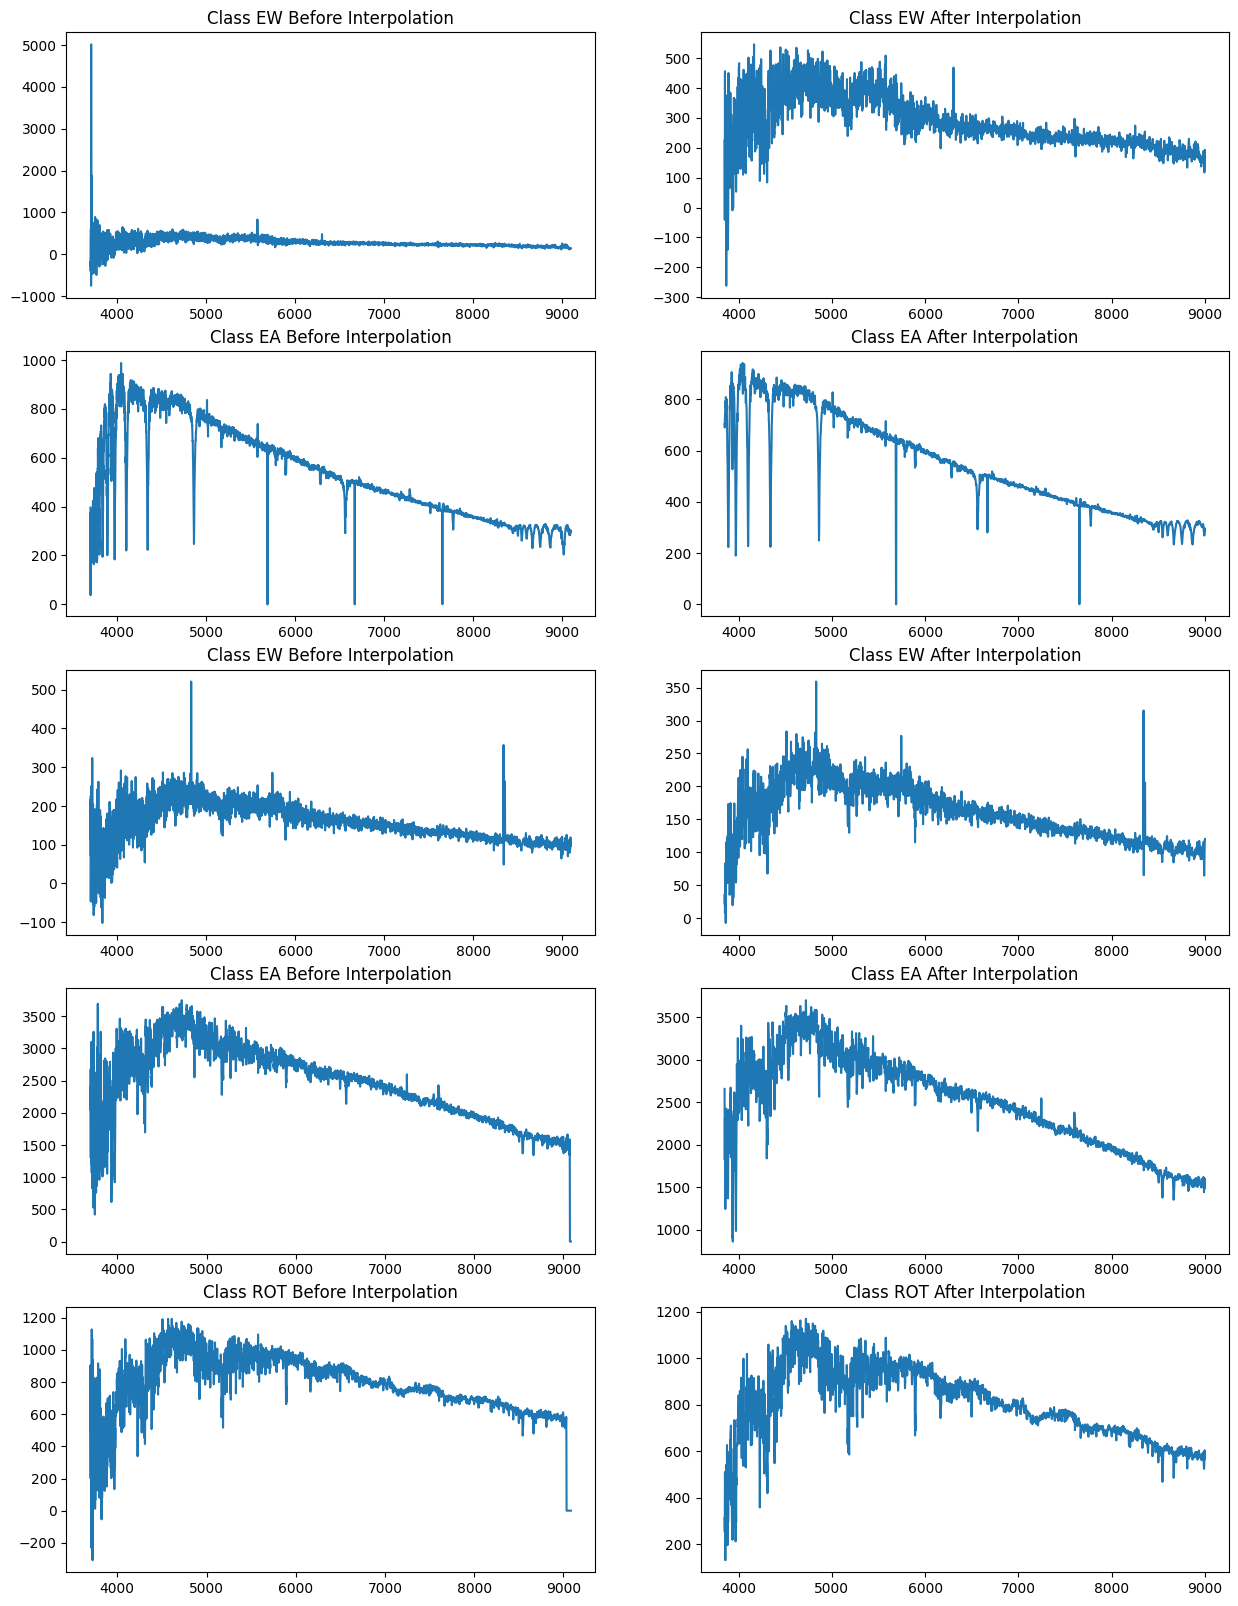

In [94]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for i in range(5):
    spectra = ds_train[i]['spectra'][0][0]
    y = ds_train[i]['classes'][0][0]

    wavelengths, fluxes = spectra[:, 0], spectra[:, 1]
    regular_wavelengths = np.arange(3850, 9002, 2)
    interpolated_fluxes = np.interp(regular_wavelengths, wavelengths, fluxes)

    axs[i, 0].plot(wavelengths, fluxes)
    axs[i, 0].set_title(f'Class {ds_train.target_lookup[y]} Before Interpolation')
    axs[i, 1].plot(regular_wavelengths, interpolated_fluxes)
    axs[i, 1].set_title(f'Class {ds_train.target_lookup[y]} After Interpolation')

plt.show()

In [28]:
ds_train[i]['spectra'][0][0][:, 0].min(), ds_train[i]['spectra'][0][0][:, 0].max()

(3699.6958, 9083.768)

In [30]:
ds_train.df['variable_type'].value_counts()

variable_type
EW       5109
SR       3846
EA       2428
RRAB     2070
EB       1656
ROT      1537
RRC       692
M         272
HADS      238
DSCT      214
DCEP       36
DCEPS      18
RRD        12
CWB        11
CWA        11
Name: count, dtype: int64